In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Normalize the data.
from sklearn import preprocessing
from sklearn.model_selection import KFold

# Reproducable results
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)

Define functions to normalize and de-normalize the data

In [2]:
# Load labeled data
data = np.loadtxt('C:/Users/berkc/git/Physics-Informed-Machine-Learning/data/labeled_data.dat')

x_exp = data[:, :2]
y_exp = data[:, -2]
y_exp = y_exp[:, np.newaxis]

Load the data by calling the function we defined above:

In [3]:
# normalize dataset with MinMaxScaler
scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
scaler2 = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
inp = scaler1.fit_transform(x_exp)
out = scaler2.fit_transform(y_exp)

# stack input and output data
data = np.column_stack((inp,out))

batch_size = 5

Define functions and classes for the BNN:

In [4]:
def to_variable(var=(), cuda=False, volatile=False):
    out = []
    for v in var:

        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        # if not v.is_cuda and cuda:
        #     v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

# # loss
# 	self.loss1 = tf.reduce_mean( tf.exp(-self.log_var) *tf.square( (self.mean-self.images) ) )
# 	self.loss2 = tf.reduce_mean(self.log_var)
# 	# "From What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?" NIPS 2017
# 	# In practice, we train the network to predict the log variance
# 	self.loss = .5*(self.loss1+self.loss2)
    
#     loss = tf.reduce_sum(0.5 * tf.exp(-1 * log_variance) * tf.square(tf.abs(y_placeholder - prediction))
#                          + 0.5 * log_variance)

def log_gaussian_loss(output, target, sigma, no_dim):
#     exponent = -0.5 * (target - output) ** 2 / sigma ** 2
#     log_coeff = -no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
    
    exponent = 0.5 * abs(target - output)**2 / sigma ** 2
    log_coeff = 0.5*torch.log(sigma)
    return (log_coeff + exponent).sum()

# def log_gaussian_loss(output, target, sigma, no_dim):
#     exponent = -0.5 * (target - output) ** 2 / sigma ** 2
#     log_coeff = -no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
#     return - (log_coeff + exponent).sum()



class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        # self.layer3 = nn.Linear(num_units, num_units)
        # self.layer4 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer3(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer4(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x


class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        self.learn_rate = learn_rate
        self.batch_size = batch_size

        self.network = network
        # self.network.cuda()

#         self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)

        # reset gradient and total loss
        self.optimizer.zero_grad()

        output = self.network(x)

        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        loss.backward()
        self.optimizer.step()

        return loss

    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)

        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())

        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1) ** 2) ** 0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)

        rmse = ((mean - y) ** 2).mean() ** 0.5

        return loss.detach().cpu(), rmse.detach().cpu()

Define the function that fits the BNN and shuffles the data and use some for testing.

In [5]:
def train_mc_dropout(data, drop_prob, ratio_train_data, num_epochs, num_units, learn_rate, weight_decay, log_every,
                     num_samples):

    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = data.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_train_data * nl)
#     idx_ = np.random.permutation(nl)
    idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]

    x_train, y_train = data[idx_train, :in_dim], data[idx_train, in_dim:]

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    x_test, y_test = data[idx_test, :in_dim], data[idx_test, in_dim:]

    y_means, y_stds = y_train.mean(axis=0), y_train.var(axis=0) ** 0.5

    net = MC_Dropout_Wrapper(
            network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
            learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    for i in range(num_epochs):

        loss = net.fit(x_train, y_train)

        tt, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        rmse_train = rmse_train.cpu().data.numpy()

        test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

        history_loss.append(loss.cpu().data.numpy() / len(x_train))
        history_loss_test.append(test_loss / len(x_test))
        history_rmse.append(rmse_train )
        history_rmse_test.append(rmse_test )

        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f' %
                    (i, loss.cpu().data.numpy() / len(x_train), test_loss / len(x_test), rmse ))

    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

    train_logliks.append((train_loss.cpu().data.numpy() / len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy() / len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(train_rmse.cpu().data.numpy())
    test_rmses.append(test_rmse.cpu().data.numpy())

    plt.figure()
    # plot history of accuracy
    # Plot training & validation accuracy values
    plt.plot(history_rmse)
    plt.plot(history_rmse_test)
    plt.title('Model accuracy')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.figure()
    # Plot training & validation loss values
    plt.plot(history_loss)
    plt.plot(history_loss_test)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test

Call the function to build the network

Epoch:    0, Train loss: -0.017 Test loss:  0.016 RMSE: 0.355
Epoch:  100, Train loss: -0.455 Test loss: -0.476 RMSE: 0.126
Epoch:  200, Train loss: -0.479 Test loss: -0.813 RMSE: 0.059
Epoch:  300, Train loss: -0.745 Test loss: -0.865 RMSE: 0.059
Epoch:  399, Train loss: -0.843 Test loss: -0.837 RMSE: 0.074


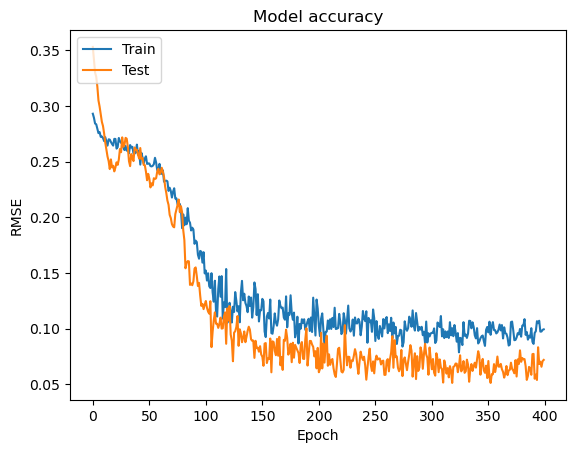

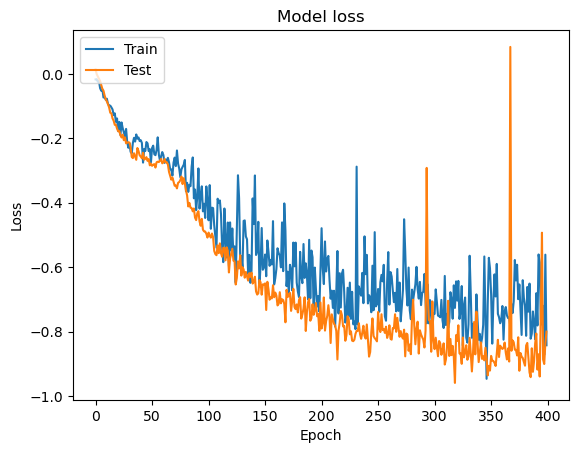

Train log. lik. =  2.052 +/-  0.000
Test  log. lik. =  2.167 +/-  0.000
Train RMSE      =  0.098 +/-  0.000
Test  RMSE      =  0.070 +/-  0.000


In [22]:
seed = 1
set_seed(seed)

nobs = 25

# Parameters
wght_decay, p_drop, learn_rate = 1e-3, 0.1, 5e-3
train_data_ratio, nb_units, nb_epochs = nobs/data.shape[0], 5, 400

net, x_tst, y_tst = train_mc_dropout(data=data, drop_prob=p_drop, num_epochs=nb_epochs, 
                                     ratio_train_data=train_data_ratio, num_units=nb_units, learn_rate=learn_rate, 
                                     weight_decay=wght_decay, num_samples=10, log_every=100)

Test the model using the unique temperature values of the test data and plot the predictions with both epistemic and aleatoric uncertainty. The epistemic uncertainty is obtained by running the BNN (MC dropout) several times.

In [9]:
# #--------------------------------------#
# # sobol samples & candidate points
# #--------------------------------------#
# n = 100
# d = x_exp.shape[1] # dimension of input

# # intialise data of lists.
# X1 = pd.DataFrame(np.random.uniform(0,1,size=(n,d)), columns=['X1', 'X2'])
# X2 = pd.DataFrame(np.random.uniform(0,1,size=(n,d)), columns=['X1', 'X2'])
# candidate = pd.DataFrame(np.random.uniform(0,1,size=(10,d)), columns=['X1', 'X2'])

In [10]:
# X1_np = X1.to_numpy()
# X2_np = X2.to_numpy()
# candidate_np = candidate.to_numpy()
# inp_sim = np.vstack((X1_np,X2_np,candidate_np))

In [53]:
# Get a tuple of unique values & their first index location from a numpy array
uniqueValues, indicesList = np.unique(x_tst[:,0], return_index=True)
x_tst = x_tst[indicesList]

# Only use the selected unique test data
y_tst = y_tst[indicesList]

x_pred = torch.tensor(x_tst.astype(np.float32)) # convert to torch tensor
# x_pred = torch.tensor(inp_sim.astype(np.float32)) # convert to torch tensor

samples = []
noises = []
for i in range(10):
    preds = net.network.forward(x_pred).cpu().data.numpy()
    samples.append(preds[:,0][:,np.newaxis])
    noises.append(preds[:,1][:,np.newaxis])

samples = np.array(samples)
samples = np.squeeze(samples)
noises = np.exp(noises)
means = (samples.mean(axis=0)).reshape(-1)

aleatoric = ((noises ** 2).mean(axis=0) ** 0.5).reshape(-1)
epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

print("Aleatoric uncertainty mean: {0:.4f}, Epistemic uncertainty mean: {1:.4f}, Total uncertainty mean: {2:.4f}"
      .format(aleatoric.mean(), epistemic.mean(), total_unc.mean()))
print("Aleatoric uncertainty std: {0:.4f}, Epistemic uncertainty std: {1:.4f}, Total uncertainty std: {2:.4f}"
      .format(aleatoric.std(), epistemic.std(), total_unc.std()))

(13,)
Aleatoric uncertainty mean: 0.1428, Epistemic uncertainty mean: 0.0539, Total uncertainty mean: 0.1549
Aleatoric uncertainty std: 0.0756, Epistemic uncertainty std: 0.0321, Total uncertainty std: 0.0777


In [54]:
total_unc

array([0.13676313, 0.20820196, 0.1152038 , 0.2559005 , 0.20391083,
       0.13954978, 0.15600537, 0.02040633, 0.11372155, 0.3295015 ,
       0.16197307, 0.11241841, 0.06069854], dtype=float32)

Plot predictions with predictive mean and variance

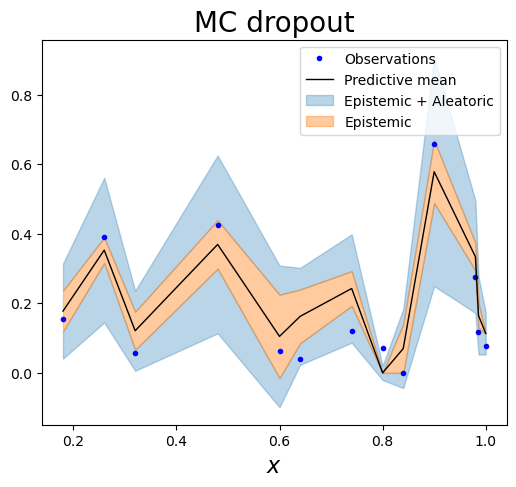

In [58]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# denormalize test data
# x_tst = denormalize_max_min(x_tst, max_x, min_x)
# y_tst = denormalize_max_min(y_tst, max_y, min_y)


# PLOT FIGURES
plt.figure(figsize=(6, 5))
plt.style.use('default')
plt.plot(x_tst[:,0], y_tst, 'b.', label='Observations');
plt.fill_between(x_tst[:,0], means + epistemic, means + total_unc, color=c[0], alpha=0.3,
                 label='Epistemic + Aleatoric')
plt.fill_between(x_tst[:,0], means - total_unc, means - epistemic, color=c[0], alpha=0.3)
plt.fill_between(x_tst[:,0], means - epistemic, means + epistemic, color=c[1], alpha=0.4,
                 label='Epistemic')
plt.plot(x_tst[:,0], means, color='black', linewidth=1, label='Predictive mean')
plt.xlabel('$x$', fontsize=16)
plt.title('MC dropout', fontsize=20)
plt.legend()
plt.savefig('pred4.pdf')  
plt.show()